# Preprocesado de las noticias

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

#Nicer style
style.use('seaborn') 

Pre-procesado para eliminar URLS, símbolos. Es decir, cosas que no son palabras

In [2]:
import re #regexp

Tokenizer de NLTK (Natural Language Tool Kit) basado en expresiones regulares.

In [3]:
from nltk.tokenize import RegexpTokenizer

### Limpieza del dataset
Cargamos el dataset de noticias

In [4]:
news = pd.read_csv("../../data/news_cleaned_2018_02_13.csv", nrows=1000)

news = news[['type', 'content', 'title']]

#Remove columns with NaNs 
news = news.dropna()

In [5]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    #tokens = word_tokenize(text)
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]
    
    # filter out stop words
    #stop_words = set(stopwords.words('english'))
    #words = [w for w in words if not w in stop_words]
    
    return words

In [6]:
news['content'] = news.apply(lambda row: clean_text(row['content']), axis=1)

### Word2Vec

<div class="alert alert-warning">
    **TODO:** Descripción
</div>

In [7]:
from gensim.models import KeyedVectors

Cargamos los vectores de un modelo entrenado por Google con los textos de millones de noticias

In [9]:
model = KeyedVectors.load_word2vec_format("../../data/GoogleNews-vectors-negative300.bin.gz", binary=True)

Un ejemplo de predicción de palabras similares a "Trump"

In [10]:
model.most_similar("Trump")

[('Donald_Trump', 0.8103920817375183),
 ('impersonator_entertained', 0.5942257046699524),
 ('Ivanka_Trump', 0.5924582481384277),
 ('Ivanka', 0.560720682144165),
 ('mogul_Donald_Trump', 0.5592452883720398),
 ('Trump_Tower', 0.5485552549362183),
 ('Kepcher', 0.5468589067459106),
 ('billionaire_Donald_Trump', 0.5447269678115845),
 ('Trumpster', 0.5412819385528564),
 ('tycoon_Donald_Trump', 0.5383971929550171)]

A continuación convertimos las palabras del contenido de las noticias en vectores para poder pasárselos a una red neuronal.

In [11]:
news['embeddings'] = news.apply(lambda r: 
                        np.array([model[x] for x in r['content'] if x in model.vocab]), axis=1)

Un ejemplo de un artículo convertido a una matriz $M$ de dimensiones $l x 300$, donde $l$ es la longitud en palabras del artículo

In [12]:
news['embeddings'][0]

array([[-0.25195312,  0.13085938,  0.05053711, ...,  0.12695312,
        -0.03833008,  0.08349609],
       [ 0.00704956, -0.07324219,  0.171875  , ...,  0.01123047,
         0.1640625 ,  0.10693359],
       [ 0.12597656,  0.19042969,  0.06982422, ...,  0.0612793 ,
         0.17285156, -0.07861328],
       ...,
       [ 0.04248047,  0.00628662,  0.00637817, ..., -0.02416992,
         0.1640625 , -0.015625  ],
       [ 0.08447266, -0.00035286,  0.05322266, ...,  0.01708984,
         0.06079102, -0.10888672],
       [ 0.11083984, -0.15820312,  0.02075195, ...,  0.15136719,
        -0.16503906,  0.01977539]], dtype=float32)

In [13]:
news['embeddings'][0].shape

(113, 300)

Pero hay un **problema**: La entrada de la red no puede ser variable. Para solucionar esto, es necesario añadir padding a todas las matrices, de tal manera que todas tengan una longitud física.

Si miden menos de una cierta longitud $n$ ($l < n$) entonces se le añadirán "filas" con ceros hasta alacanzar las dimensiones necesarias. Si mide más, se cortará de tal manera que $l = n$

In [14]:
def pad_matrix(matrix, token_len):
    """
    Funcion para añadir padding a una matriz hasta que tenga el número de filas 
    necesario.
    
    :param: token_len (int) longitud deseada en filas de la matriz
    :return: matriz con las dimensiones necesarias. 
    """
    tensor_token, depth = matrix.shape
    diff_token = token_len - tensor_token
    if(diff_token < 0):
        matrix = matrix[:token_len,:] #Select only part
    else:
        #Pad
        matrix = np.pad(matrix, ((0,diff_token),(0,0)), mode='constant', constant_values=0)
        
    return matrix

Es necesario encontrar un `token_len` que sea suficiente para que cubra, en general, la longitud de todos los artículos.

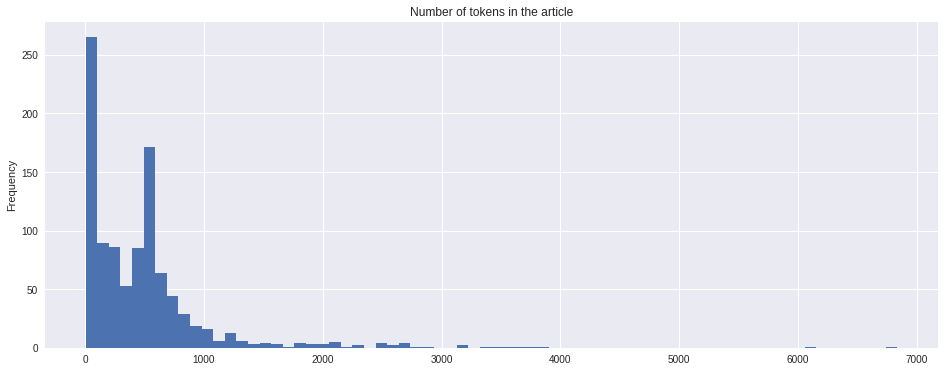

In [15]:
# Longitud en tokens de cada noticia
tokens_numbers = news.apply(lambda row: len(row['content']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)

In [16]:
print("Número medio de tokens por artículo: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por artículo: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por artículo: {}".format(int(np.median(tokens_numbers))))

Número medio de tokens por artículo: 482
Desviación estándar de tokens por artículo: 595
Mediana de tokens por artículo: 402


Escogemos el número máximo como $mean + 2\sigma$

In [17]:
max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

Ventana de tokens escogida: 1673 - Cubre el 95.88766298896691% del dataset


In [18]:
n_tokens = max_tokens

In [19]:
news['embeddings'] = news.apply(lambda r: pad_matrix(r['embeddings'], n_tokens) , axis=1)

In [20]:
news['embeddings'][0].shape

(1673, 300)

### Convertir variable objetivo a OneHot Encodding

In [21]:
encoder = LabelBinarizer().fit(list(news['type']))
news['one_hot_label'] = news.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

In [22]:
news.head()

,type,content,title,embeddings,one_hot_label
0,rumor,"[Life, is, an, illusion, at, least, on, a, qua...",Is life an ILLUSION? Researchers prove 'realit...,"[[-0.25195312, 0.13085938, 0.05053711, -0.0417...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
1,hate,"[Unfortunately, he, hasn, yet, attacked, her, ...",Donald Trump,"[[-0.20800781, 0.25585938, -0.080566406, -0.01...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
2,hate,"[The, Los, Angeles, Police, Department, has, b...",Donald Trump,"[[-0.17285156, 0.27929688, 0.106933594, -0.158...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,hate,"[The, White, House, has, decided, to, quietly,...","MORE WINNING! Israeli intelligence source, DEB...","[[-0.17285156, 0.27929688, 0.106933594, -0.158...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,hate,"[time, has, come, to, cut, off, the, tongues, ...","“Oh, Trump, you coward, you just wait, we will...","[[-0.04736328, 0.1875, 0.0022583008, 0.1738281...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


Guardamos el dataset procesado como `.pickle` (serializado de objetos python).

In [25]:
news.to_pickle("../../data/news_processed.pickle")